<a href="https://colab.research.google.com/github/PrajwalRaut8/Predicting-Sales-for-Lemonade/blob/main/Predicting_sales_of_lemonade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
from torch import nn

import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was deteected.'.format(device))

A cuda device was deteected.


In [47]:
if device == 'cude':
  print(torch.cuda.get_device_name(device=device))

In [48]:
import pandas as pd
url = 'https://raw.githubusercontent.com/LeakyAI/FirstNeuralNet/main/lemons.csv'
df = pd.read_csv(url)
df.head(10)

,Weekend,Sunny,Warm,BigSign,Price,NumberSold
0,1,0,0,1,9,71
1,1,1,1,0,10,137
2,0,1,0,0,10,0
3,1,0,0,1,6,107
4,1,0,0,1,8,80
5,1,1,0,0,6,110
6,1,1,1,0,8,167
7,0,0,1,1,8,0
8,1,0,1,0,8,124
9,1,1,0,0,7,95


In [49]:
df.shape

(365, 6)

Now we should standardize the data of price and Number sold, because neural networks train better with standardized data.

In [50]:
priceMean = df['Price'].mean()
priceStd = df['Price'].std()
df['Price'] = (df['Price']-priceMean)/priceStd

In [51]:
numSoldMean = df['NumberSold'].mean()
numSoldStd = df['NumberSold'].std()
df['NumberSold'] = (df['NumberSold']-numSoldMean)/numSoldStd

Now we will create our Input (x) and Output (y) to Train our Neural Network



In [52]:
inputs = ['Weekend', 'Sunny' ,'Warm', 'BigSign', 'Price']
x = torch.tensor(df[inputs].values, dtype=torch.float, device = device)

In [53]:
outputs = ['NumberSold']
y = torch.tensor(df[outputs].values, dtype = torch.float, device = device)

In [54]:
x[0:5]

tensor([[ 1.0000,  0.0000,  0.0000,  1.0000,  0.8467],
        [ 1.0000,  1.0000,  1.0000,  0.0000,  1.4526],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.4526],
        [ 1.0000,  0.0000,  0.0000,  1.0000, -0.9712],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.2407]], device='cuda:0')

In [55]:
y[0:5]

tensor([[-0.0237],
        [ 0.7437],
        [-0.8492],
        [ 0.3949],
        [ 0.0810]], device='cuda:0')

Now building the neural network

In [56]:
model = nn.Sequential(
    nn.Linear(5,100),
    nn.ReLU(),
    nn.Linear(100,1)
)

In [57]:
model.to(device)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

Now Training the Neural Network

In [58]:
import torch.optim as optim

In [59]:
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(5):
  totalLoss = 0
  for i in range(len(x)):
    ypred = model(x[i])

    loss = criterion(ypred, y[i])

    totalLoss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("total loss: ", totalLoss)

total loss:  138.98431747327118
total loss:  10.833906714717571
total loss:  5.4370080345843235
total loss:  4.241128735090342
total loss:  3.292672245518421


Analyze the Network's Performance

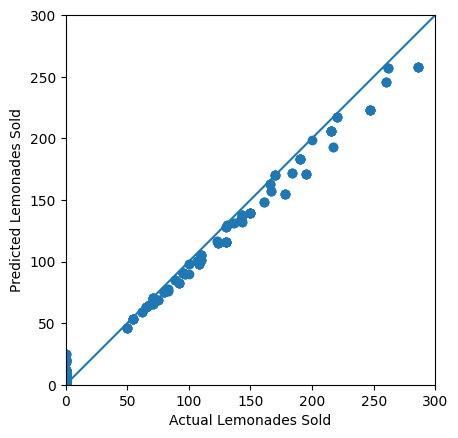

In [60]:
@torch.no_grad()
def graphPredictions(model, x, y, minValue, maxValue):
  model.eval()

  predictions=[]
  actual=[]

  x.to(device)
  y.to(device)
  model.to(device)

  for i in range(len(x)):
    pred = model(x[i])

    pred = pred*numSoldStd+numSoldMean
    act= y[i]*numSoldStd+numSoldMean

    predictions.append(pred.tolist())
    actual.append(act.item())

  plt.scatter(actual, predictions)
  plt.xlabel('Actual Lemonades Sold')
  plt.ylabel('Predicted Lemonades Sold')
  plt.plot([minValue, maxValue], [minValue, maxValue])
  plt.xlim(minValue, maxValue)
  plt.ylim(minValue, maxValue)

  plt.gca().set_aspect('equal', adjustable = 'box')
  plt.show()

graphPredictions(model, x, y, 0, 300)

Test with custom input

In [61]:
def datasetGenerator(weekend, sunny, warm, bigsign, price):
  numlemonssold = 0
  if weekend:
    numlemonssold = (sunny*5 + int(500/price))
    if bigsign:
      numlemonssold = 1.3 * numlemonssold
    if warm:
      numlemonssold = 2 * numlemonssold
    if sunny:
      numlemonssold = 1.25 * numlemonssold
  numlemonssold = int(numlemonssold)

  return numlemonssold

In [62]:
weekend = 1
sunny = 1
warm = 1
bigsign = 0
price = 5

actual = datasetGenerator(weekend, sunny, warm, bigsign, price)

model.to('cpu')

price = (price - priceMean) / priceStd

x1 = torch.tensor([weekend, sunny, warm, bigsign, price], dtype=float)
y1 = model(x1.float())

y1 = y1*numSoldStd + numSoldMean

print("neural Network Predicts: ", y1.item())
print("Actual Result: ", actual)

neural Network Predicts:  256.7909851074219
Actual Result:  262
